In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout, LeakyReLU
from keras.optimizers import Adam, RMSprop

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image

import tensorflow as tf
import math

Using TensorFlow backend.
/home/thomas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/thomas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/thomas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/thomas/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:
SAMPLE_DIM = 2

In [3]:
# Objective function; Achieve at least .65 with the test vector
def ring_objective(preds):
    dists = np.sqrt(preds[:,0]**2 + preds[:,1]**2).reshape(-1)
    return np.mean(np.where(np.abs(dists - 1) <= 0.1, 1, 0))

In [4]:
# config = tf.ConfigProto(
#         device_count = {'GPU': 0}
#     )
# sess = tf.Session(config=config)
# ktf.set_session(sess)

In [5]:
def discriminator():
    net = Sequential()
    net.add(Dense(32, input_dim=2))
    net.add(LeakyReLU())
    net.add(Dense(16))
    net.add(LeakyReLU())
    net.add(Dense(4))
    net.add(LeakyReLU())
    net.add(Dense(1, activation='sigmoid'))
    
    return net

In [6]:
def generator():
    net = Sequential()
    net.add(Dense(32, input_dim=SAMPLE_DIM))
    net.add(LeakyReLU())
    net.add(Dense(16))
    net.add(LeakyReLU())
    net.add(Dense(4))
    net.add(LeakyReLU())
    net.add(Dense(2))
    
    return net

In [7]:
net_discriminator = discriminator()
net_generator = generator()

In [8]:
optim_discriminator = Adam(lr=0.0003, clipvalue=1.0, decay=1e-10)
model_discriminator = Sequential()
model_discriminator.add(net_discriminator)
model_discriminator.compile(loss='binary_crossentropy', optimizer=optim_discriminator, metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
optim_adversarial = Adam(lr=0.00015, clipvalue=1.0, decay=1e-10)
model_adversarial = Sequential()
model_adversarial.add(net_generator)

# Disable layers in discriminator
for layer in net_discriminator.layers:
    layer.trainable = False

model_adversarial.add(net_discriminator)
model_adversarial.compile(loss='binary_crossentropy', optimizer=optim_adversarial, metrics=['accuracy'])

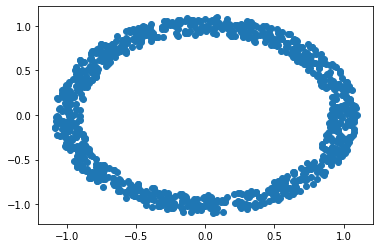

In [10]:
# x_train = np.random.normal((0, 5), 1, [1000, 2])
CIRCLE_RADIUS = 1
CIRCLE_DEV = 1

rads = np.random.uniform(0, 2*math.pi, size=[1000, 1])
rand_rads = np.random.uniform(0.9, 1.1, size=[1000, 1])

x_train = np.hstack((np.cos(rads)*CIRCLE_RADIUS*rand_rads, np.sin(rads)*CIRCLE_RADIUS*rand_rads))


plt.scatter(x_train[:,0], x_train[:,1])

plt.show()

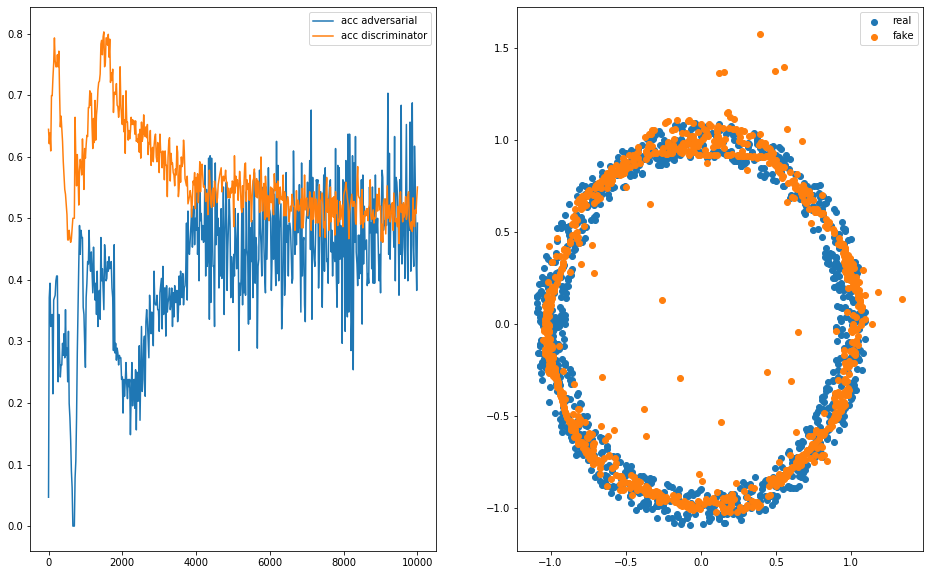

0.949


In [12]:
batch_size = 256

vis_noise = np.random.normal(0, 1.0, size=[1000, SAMPLE_DIM])

loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []


with tf.device('/cpu:0'):
    for i in range(10001):

        for u in range(1):
            # Take random samples
            numbers_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :]

            # Generate a random noise vector
            noise = np.random.normal(0, 1.0, size=[batch_size, SAMPLE_DIM])

            # Use the generator to create fake samples
            fake = net_generator.predict(noise)

            # Create a dataset with fake and real samples
            x = np.concatenate((numbers_train, fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0 


            # Train discriminator for one batch
            d_stats = model_discriminator.train_on_batch(x, y)

        # Train the generator
        # The input of th adversarial model is a list of noise vectors. The generator is 'good' if the discriminator classifies
        # all the generated samples as real. Therefore, the desired output is a list of all ones.
        y = np.ones([batch_size, 1])
        noise = np.random.normal(0, 1.0, size=[batch_size, SAMPLE_DIM])
        a_stats = model_adversarial.train_on_batch(noise, y)

        if i % 20 == 0:
            plot_iteration.append(i)
            loss_adv.append(a_stats[0])
            loss_dis.append(d_stats[0])
            acc_adv.append(a_stats[1])
            acc_dis.append(d_stats[1])

            clear_output(wait=True)

            fig, axes = plt.subplots(1,2)
            fig.set_size_inches(16, 10)

            axes[0].plot(plot_iteration, acc_adv, label="acc adversarial")
            axes[0].plot(plot_iteration, acc_dis, label="acc discriminator")
            axes[0].legend()

            #axes[0, 1].plot(plot_iteration, acc_adv, label="acc adversarial")
            #axes[0, 1].plot(plot_iteration, acc_dis, label="acc discriminator")
            #axes[0, 1].legend()

            # Visualize the performance of the generator by producing samples from the test vector
            generated = net_generator.predict(vis_noise)
            axes[1].scatter(x_train[:,0], x_train[:,1], label="real")
            axes[1].scatter(generated[:,0], generated[:,1], label="fake")
            axes[1].legend()
            plt.show()
            print(ring_objective(generated))